# Camera Calibration

scikit-surgerycalibration provides a range of functions/classes mono, stereo and hand-eye calibration.

The Jupyter notebook for this page can be found in the docs/tutorials folder of the [code repository](https://github.com/SciKit-Surgery/scikit-surgerycalibration).

* Setting up paths and virtual environment
```
cd $HOME/repositories/Scikit-Surgery/scikit-surgerycalibration
export PYTHONPATH=$HOME/repositories/Scikit-Surgery/scikit-surgerycalibration
conda activate scikit-surgerycalibrationVE
```


## Required modules
This tutorial requires numpy, opencv-contib-python, scikit-surgeryimage, scikit-surgerycalibration, and matplotlib (for inline image plotting).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sksurgeryimage.calibration.chessboard_point_detector as cpd
import sksurgerycalibration.video.video_calibration_driver_mono as mc

## Chessboard Calibration

The calibrator can be used with any of the point detectors available in [scikit-surgeryimage](https://github.com/SciKit-Surgery/scikit-surgeryimage).

In this example, we will use the chessboard detector, see the [Point Detectors Tutorial](https://scikit-surgeryimage.readthedocs.io/en/latest/tutorials/point_detectors.html) for some examples of other options.

We will use [this](https://github.com/SciKit-Surgery/scikit-surgerybard/blob/master/data/calibrationGrids/calibrationgrid-6mm.pdf) 14x10 chessboard pattern for calibration. 
<img src="14x10_chessboard.png" width="200" alt="Convolution">
   
You can either print it out, or display it on a mobile phone. If printed, the square size is 6mm, you will have to measure/estimate the size if displayed on a phone screen.




### Initial setup

In [2]:
chessboard_corners = (14, 10)
min_points_to_detect = chessboard_corners[0] * chessboard_corners[1]
square_size_mm = 6 # Change as appropriate if displayed on phone

video_source = cv2.VideoCapture(0)

detector = cpd.ChessboardPointDetector(chessboard_corners, square_size_mm)
calibrator = mc.MonoVideoCalibrationDriver(detector, min_points_to_detect)


### Capture some frames

If you hold the chessboard in view of your camera, and run the below cell repeatedly, it will grab some frames. At least 2 frames are needed for a calibration, but in general the more frames, the better the calibration.

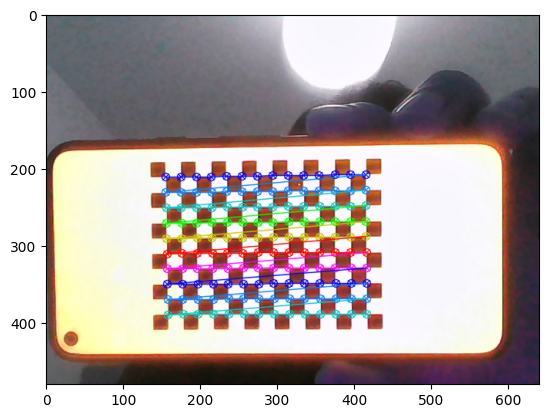

Detected 140 corners
3 frames captured


In [5]:
# Read a frame and detect points 
_, frame = video_source.read()
number_of_points = calibrator.grab_data(frame)

# Draw chessboard points on frame
if number_of_points > 0:
    img_pts = calibrator.video_data.image_points_arrays[-1]
    ###print(img_pts.shape)##(140, 1, 2)
    frame = cv2.drawChessboardCorners(frame, 
                                      chessboard_corners,
                                      img_pts,
                                      number_of_points)
plt.imshow(frame)
plt.show()

# Print some details
number_of_views = calibrator.get_number_of_views()
print(f"Detected {number_of_points} corners")
print(f"{number_of_views} frames captured")

### Perform calibration

In [6]:
if number_of_views > 1:
    proj_err, params = calibrator.calibrate()
    #proj_err, recon_err, params = calibrator.calibrate()
    print(f'Reprojection (2D) error is: \n {proj_err}')    
    #print(f'Reprojection (3D) error is: \n {recon_err}')    
    print(f'Intrinsics are: \n  {params.camera_matrix}')
    print(f'Distortion matrix is:  \n {params.dist_coeffs}')    

Reprojection (2D) error is: 
 0.19281401614557028
Intrinsics are: 
  [[809.69585633   0.         432.93998965]
 [  0.         802.69795671 291.847329  ]
 [  0.           0.           1.        ]]
Distortion matrix is:  
 [[-0.06609416 -0.10402796  0.00859668  0.00367779  2.34223261]]


In [7]:
video_source.release()

## Dot Calibration

We will use [this](https://scikit-surgeryimage.readthedocs.io/en/latest/_images/dot_pattern.png) dot pattern. 
<img src="dot_pattern.png" width="200" alt="Convolution">

Due to the relatively small size of the dots, performance when displayed on a phone screen may vary.

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sksurgeryimage.calibration.dotty_grid_point_detector as dpd
import sksurgerycalibration.video.video_calibration_driver_mono as mc

### Initial setup for dot detector

In [9]:
number_of_dots = [18, 25]
pixels_per_mm = 80
dot_separation = 5

# Don't need to capture all dots for calibration to work
min_points_to_detect = (number_of_dots[0] / number_of_dots[1]) / 2
model_points = dpd.get_model_points(number_of_dots,
                                         pixels_per_mm,
                                         dot_separation)

# Location of the large dots in the pattern
fiducial_indexes = [132, 142, 307, 317]

# Image size
reference_image_size = [1900, 2600]

# data in scikit-surgerycalibration/tests/data/dot_calib
left_intrinsic_matrix = np.loadtxt("../../tests/data/dot_calib/calib.left.intrinsics.txt")
left_distortion_matrix = np.loadtxt("../../tests/data/dot_calib/calib.left.distortion.txt")

video_source = cv2.VideoCapture(0)


detector = \
    dpd.DottyGridPointDetector(
        model_points,
        fiducial_indexes,
        left_intrinsic_matrix,
        left_distortion_matrix,
        reference_image_size=(reference_image_size[1],
                                reference_image_size[0])
        )

calibrator = mc.MonoVideoCalibrationDriver(detector, min_points_to_detect)



### Capture some frames

If you hold the chessboard in view of your camera, and run the below cell repeatedly, it will grab some frames. At least 2 frames are needed for a calibration, but in general the more frames, the better the calibration.

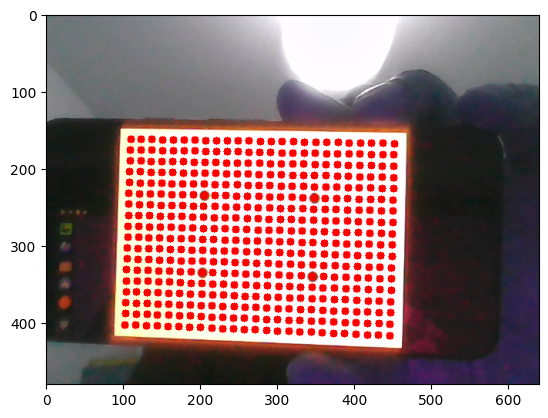

Detected 450 points
3 frames captured


In [12]:

# Read a frame and detect points 
_, frame = video_source.read()
number_of_points = calibrator.grab_data(frame)

if number_of_points > 0:
    img_pts = calibrator.video_data.image_points_arrays[-1]
    ###print(img_pts.shape)##(448, 1, 2)
    # Draw detected points on frame
    for point in img_pts:
        frame = cv2.circle(frame, ( int(point[0,0]), int(point[0,1])), 5, (255, 0 ,0), -1)

plt.imshow(frame) 
plt.show()

# Print some details
number_of_views = calibrator.get_number_of_views()
print(f"Detected {number_of_points} points")
print(f"{number_of_views} frames captured")


### Release video_source

In [13]:
video_source.release()

### Perform Calibration

In [14]:
if number_of_views > 1:
    proj_err, params = calibrator.calibrate()
    #proj_err, recon_err, params = calibrator.calibrate()
    print(f'Reprojection (2D) error is: \n {proj_err}')    
    #print(f'Reprojection (3D) error is: \n {recon_err}')    
    print(f'Intrinsics are: \n  {params.camera_matrix}')
    print(f'Distortion matrix is:  \n {params.dist_coeffs}')
    

Reprojection (2D) error is: 
 0.08160305101574904
Intrinsics are: 
  [[546.86680246   0.         342.68154282]
 [  0.         545.55158144 232.75969187]
 [  0.           0.           1.        ]]
Distortion matrix is:  
 [[-0.05469762  0.2762558   0.00113643  0.00038568 -0.35911484]]


## Stereo Calibration

Stereo calibration works in the same way as mono calibration, except with two detectors and two images:

```
import sksurgerycalibration.video.video_calibration_driver_stereo as sc

# Define detectors

calibrator = sc.StereoVideoCalibrationDriver(left_detector,
                                           right_detector,
                                           min_points)
                                           
# Acquire images

number_of_points = calibrator.grab(left_image, right_image)
```